# Analysis of Battleship Game

## Introduction

This article will try and analyse the game of the [Battleship](https://en.wikipedia.org/wiki/Battleship_(game)) board game. I try come put with a mathematically motivated strategy, inspired by an [article](https://austinrochford.com/posts/2021-09-02-battleship-bayes.html) by Anthony Rochford. I formalise these ideas in my own way, and build upon them to account for the opposing player's strategy.

We first import necassary packages.

In [2]:
import numpy as np
import random
random.seed(42)

import seaborn as sns
import matplotlib.pylab as plt

## Game API

We represent the opponent's board as a 2D array with value 'None' if tile has no ship. Otherwise the tile contains the string name of the ship at that tile.

In [3]:
# Class to represent an opponent's board and the relevant API functions
class OpponentBoard:
    def __init__(self):
        self.board = np.array([[None] * 10] * 10)
        self.ship_to_count = {} # Keep track of number of live tiles of each ship
        
    def __str__(self):
        return str(self.board)
    
    def is_hit(self, row, col):
        """Check if a shot is a hit. If it is a hit, track the number of remaining live tiles of ship. 
            This assumed that row, col have not been guessed before."""
        if not self.board[row, col]:
            return False
        else:
            self.ship_to_count[self.board[row, col]] -= 1
            return True
    
    def is_sunk(self, ship_name):
        """Check if a ship has been sunk."""
        return self.ship_to_count[ship_name] == 0

    def place_ship(self, ship, row, col, is_vert):
        """Place a ship on the board. row, col are the top left corner of the ship. is_vert indicates if ship is vertical. 
            returns True if ship is placed, False if ship overlaps with another ship."""
        if is_vert:
            # Make sure ship does not overlap with other ships
            board_slice = self.board[row:row + ship.length, col]
            if np.any(board_slice):
                return False
            self.board[row:row + ship.length, col] = ship.name
        else:
            # Make sure ship does not overlap with other ships
            board_slice = self.board[row, col:col + ship.length]
            if np.any(board_slice):
                return False
            self.board[row, col:col + ship.length] = ship.name

        # Add ship to dictionary of placed ships
        self.ship_to_count[ship.name] = ship.length
        return True
        
    def reset_board(self):
        self.board = np.array([[None] * 10] * 10)
        self.ship_to_count = {}
    
    def place_ships_randomly(self, ships):
        """Generate the board with ships placed randomly."""
        
        # Sequentially place ships till all ships are successfully placed (no overlap)
        for ship in ships:
            while True:
                is_vert = random.choice([True, False])
                row_max = 10 - ship.length if is_vert else 9
                col_max = 10 - ship.length if not is_vert else 9
                row, col =random.randint(0, row_max), random.randint(0, col_max)
                if self.place_ship(ship, row, col, is_vert): break

    def plot_board(self):
        """Plot the board."""
        # Map each ship to a unique integer: 0 is empty, 1 is ship 1, 2 is ship 2, etc.
        colour_map = np.zeros(self.board.shape)
        for ship_id, ship_name in enumerate(self.ship_to_count.keys(), start=1):
            colour_map[self.board == ship_name] = ship_id

        plt.title('Battleship Board')
        sns.heatmap(colour_map, linewidths=0.5, cmap="tab20c", linecolor="black", cbar=False)
        plt.show()

We then have 5 types of ships: Carried, Battleship, Cruiser, Submarine and Destroyer. These have length 5, 4, 3, 3 and 2 respectively. 

In [4]:
class Ship:
    def __init__(self, name, length):
        self.name = name
        self.length = length

ships = [Ship("Carrier", 5), Ship("Battleship", 4), Ship("Cruiser", 3), Ship("Submarine", 3), Ship("Destroyer", 2)]

We can now initialise a new board and place a ship

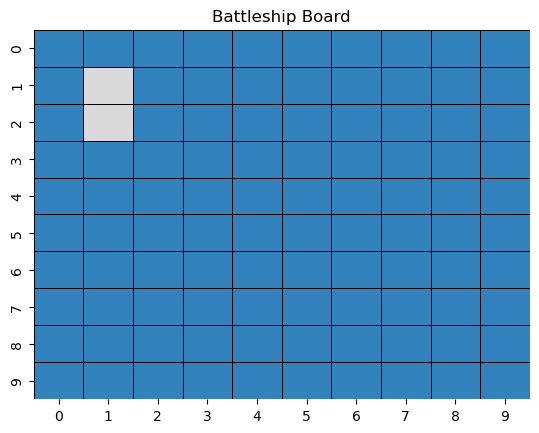

In [5]:
test_board = OpponentBoard()

# Lets place the Destroyer at row 1, col 1 and placed vertically
test_board.place_ship(ships[-1], row=1, col=1, is_vert=True)
test_board.plot_board()

Lets try randomly placing all our ships now

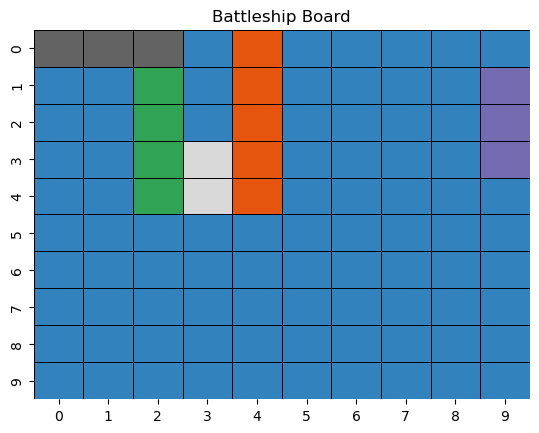

In [6]:
test_board.reset_board() # Reset board to place new ships
test_board.place_ships_randomly(ships)
test_board.plot_board()

## Computing the Probabilities

We now come to the task of mathematically modelling the game board. First, however, notice that the game lies on a $10 \times 10$ grid. One approach is to model each tile as a seperate random variable. 

$$\text{Definition: } X^{(r,c)} \text{ represents the tile at row r and column c. } X^{(r,c)} = 1 \text{ if that tile is a ship } X^{(r,c)} = 0 \text{ otherwise.}$$
Notice that $X^{(r, c)} \sim Ber(\theta^{(r, c)})$. Hence, $P(X^{(r,c)} = 1) = \theta^{(r, c)}$ is the probability that tile (r, c) has a boat.

Also, we make no i.i.d. assumptions for $X^{(r,c)}$ variables. Since, for example, if we know tile (r, c) has a ship, then we can conclude that adjacent tiles are more likely to be ships as well. In fact, this conditioning on known variables will guide our strategy.

Now, we need to find the values of $P(X^{(r,c)} = 1) = \theta^{(r,c)}$: the probability that the (r, c) tile contains a ship. We know that $X^{(r,c)} \sim Ber(\theta^{{(r,c)}})$. Hence, our maximum likelyhood estimator gives us:
$$P(X^{(r,c)} = 1) \approx \theta^{(r, c)}_{MLE} = \frac{1}{n} \sum_{i=1}^{n} x^{(r,c)}_i$$ 

where $x_i^{(r,c)}$ is our $i^{\text{th}}$ observation for the (r,c) tile from our monete carol. $n$ is the number of trails we do. 

Let's now caluculate these probabilities on out opponent's board.

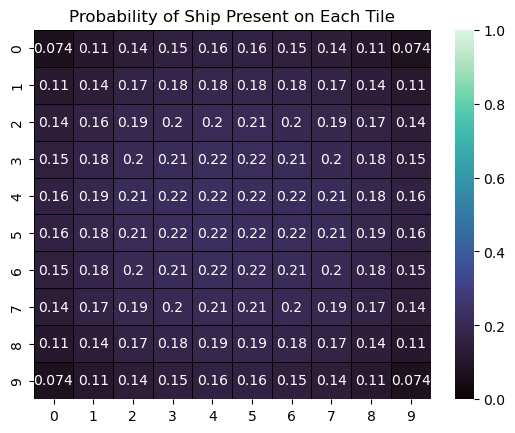

In [7]:
class ProbabilityGenerator:
    def __init__(self, number_trials=10**4, conditions=None, sunk_ships=None):
        self.number_trials = number_trials
        self.conditions = conditions if conditions else []
        self.sunk_ships = sunk_ships if sunk_ships else []

        self.probabilities = np.zeros((10, 10))

    def __satisfies_conditions(self, board):
        """Check if the board satisfies the conditions"""
        for row, col, has_ship in self.conditions:
            if (not has_ship) and board.board[row, col] != None:
                return False
            if has_ship and board.board[row, col] == None:
                return False
        return True

    def generate_probabilities(self):
        """Generate a heatmap of the probability of a ship being in each square."""
        board = OpponentBoard()
        ship_count_heatmap = np.zeros((10, 10))

        # List of non-sunk ships
        sunk_ships_ = [ship for ship, _, _, _ in self.sunk_ships]
        remaining_ships = [ship for ship in ships if ship not in sunk_ships_]

        for _ in range(self.number_trials):
            while True:
                board.reset_board()
                
                # Place the ships we have sunk (known locations)
                for ship, row, col, is_vert in self.sunk_ships:
                    board.place_ship(ship, row, col, is_vert)
                
                # Place the remaining ships randomly
                board.place_ships_randomly(remaining_ships)

                if self.__satisfies_conditions(board): break
                
            ship_count_heatmap += (board.board != None).astype(int)
                          
        self.probabilities = ship_count_heatmap / self.number_trials

    def plot_probability_heatmap(self):
        """Plot a heatmap of the probability of a ship being in each square."""
        plt.title('Probability of Ship Present on Each Tile')
        sns.heatmap(self.probabilities, linewidths=0.5, annot=True, cmap="mako", linecolor="black", cbar=True, vmin=0, vmax=1)
        plt.show()

n = 10**5
generator = ProbabilityGenerator(n)
generator.generate_probabilities()
generator.plot_probability_heatmap()

This makes sense. The centre tiles are much more likely to contain ships since there are many ways we can arrage ships in the centre, whereas there fewer ways near the borders. 

Now, what happends to these probabilities when we shoot at a tile? One way to approach this is by conditioning on the result. For example, lets assume we shoot the tile with row index 4 and column index 4. On no, we missed! Therefore, we now need to find $ P(X^{(r,c)} = 1 | X^{(4,4)} = 1) $. As before $ X^{(r,c)} | X^{(4, 4)} = 1 $ follows a bernouli distribution. Hence we can using our maximum likelyhood aproximator again to get:

$$P(X^{(r,c)} = 1 | X^{(4,4)} = 1) \approx \frac{1}{n} \sum_{i=1}^{n} x^{(r,c)}_i$$

$$\text{Subject to: } x^{(4,4)}_i = 1$$

We now run run a similair monte carlo to the one above, but now only counting boards with $ x^{(4,4)}_i = 1$.

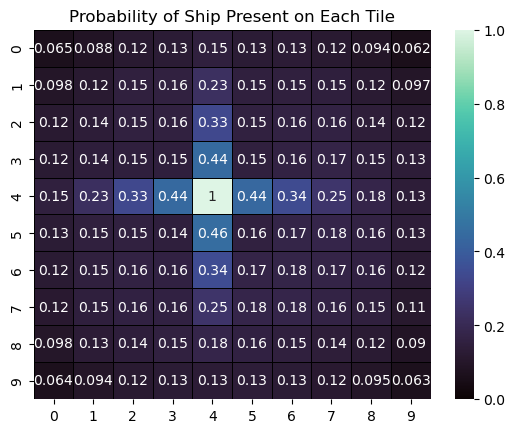

In [8]:
n = 10**4
condition = (4, 4, True)

generator = ProbabilityGenerator(number_trials=n, conditions=[condition])
generator.generate_probabilities()
generator.plot_probability_heatmap()

This approach works for an arbitraty amount of conditions since we know that the random variable $X^{(r,c)} | A$ follows a bernoulli distibution for any set of conditions $A$.

For example, lets imaging we shoot tile (4, 4), (5, 5) and (3, 6) and miss all. Then the probability of each tile containing a ship would be as follows.

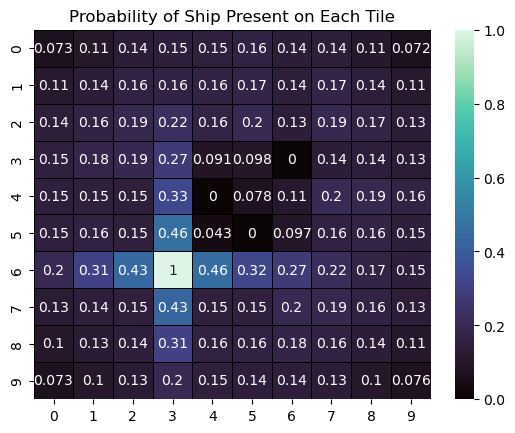

In [9]:
n = 10**4
conditions = [(4, 4, False), (5, 5, False), (3, 6, False), (6, 3, True)]

generator = ProbabilityGenerator(number_trials=n, conditions=conditions)
generator.generate_probabilities()
generator.plot_probability_heatmap()

We have dealt with hits and misses; however, we have not yet considered the sinking of ships. When we hit all tiles of a opposing player's ship, the opposing player must annouce which ship we have sunk. Let's try considering this information in our model.

Abusing notation slightly, we can write the probability of a tile being a hit given our knowlege from the $n$ previous turns as:
$$P(X^{(r,c)} = 1 | X^{(r_0,c_0)} = i_0, ...,X^{(r_n,c_n)} = i_n, C)$$

where $C$ is the set of ship we have sunk so far. 

As an example, lets assume that we have sunk the battle ship at row 4, col 4. The corresponding probabilities would be as follows once we incorporate this information.

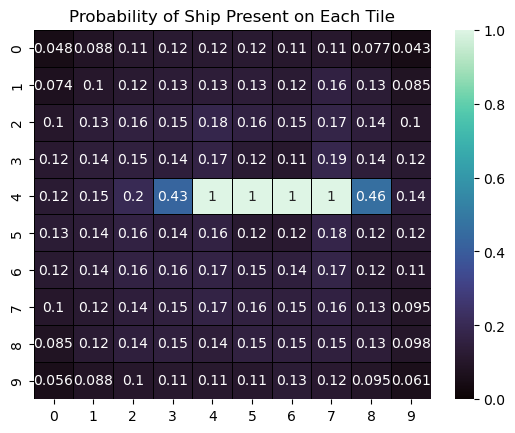

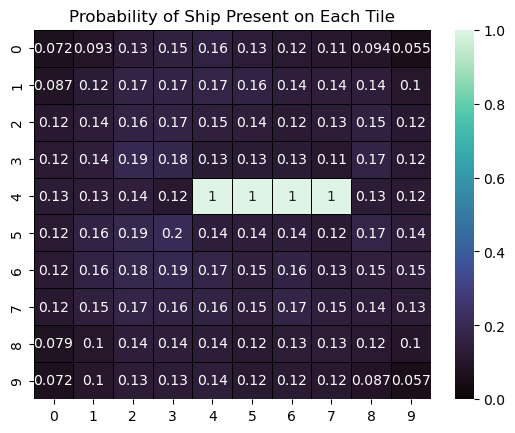

In [10]:
n = 10**3
conditions = [(4, 4, True), (4, 5, True), (4, 6, True), (4, 7, True)]

# Porbability without information of sunk ships
generator = ProbabilityGenerator(number_trials=n, conditions=conditions)
generator.generate_probabilities()
generator.plot_probability_heatmap()

# Probability with information of sunk ships
sunk_ships = [(ships[1], 4, 4, False)] # The Battleship (lenght 4) is sunk at row 4, col 4 and placed horizontally
generator = ProbabilityGenerator(number_trials=n, conditions=conditions, sunk_ships=sunk_ships)
generator.generate_probabilities()
generator.plot_probability_heatmap()

## Modelling Performance

Now lets not forget out goal: be the first to hit all 17 boat tiles of the opponent. One way to this is by minimising the time it takes to hit all ships. 

$$\text{Definition: } T_s \text{ is the number of turns it takes us to sink all 5 enemy ships with strategy }s\text{.}$$

We can therefore quantify the performance of our strategy using $E[T_s]$.

Note, however, $E[T_s]$ does not capture the entire picture regarding the success of a strategy: winning is dependent on the performance of the other player as well. For example, let's say player 1 has strategy $s_1$ and player 2 has strategy $s_2$, and $E[T_{s_1}] = E[T_{s_2}]$. Then, $s_1$ might be a better strategy than $s_2$ if $var[T_{s_1}] > var[T_{s_2}]$. However, this is simply an intuition and will be proven and/or tested.

It's difficult for us to determine $E[T_s]$ without knowing its distribution, so for know we simply assume that $E[T_s] \approx \bar{T_s}$.


In [11]:
# TODO: WE CAN DISCUSS THE GENERLISED LOSS VS SAMPLE LOSS. ALSO WE CAN EXPRESS T AS A FUNCTION OF S (OUR STRATEGY TAKES INTO ACCOUN TINITAL DIS)

## Strategy

Before developing out strategy, we must emphasise that we have made one, rather sever, assumtions. That the opposing player places their ships randomly initially. However, for now lets assume this is true, and then we'll see how we can adapt out apporach later.

At each stage of the game we have the probability of a ship on each tile. Using this information we must find an approach of choosing the next tile to target. We layout two inuitive strategies for this, including randomly shooting tiles to create a benchmark.

Random Strategy ($s_0$): Randmly choosing the next tile to shoot. 

Maximum Porbability ($s_1$): An obvious approach would be to choose tile with the maximum probability. 

Weighted Probabilities ($s_2$): Another might be to choose a tile randomly but linearly weighted based on each respective probability. This might lead to higher variance in $T_{s_1}$.

In [26]:
def count_turns_random_strategy(opposing_board):
    available_tiles = [(i, j) for i in range(10) for j in range(10)]

    hit_count = 0
    total_turns = 0
    while hit_count < 17:
        row, col = random.choice(available_tiles)
        available_tiles.remove((row, col))
        if opposing_board.board[row, col]:
            hit_count += 1
        total_turns += 1
    return total_turns

opposing_board = OpponentBoard()
num_trials = 10**6
total_turns = 0
for _ in range(num_trials):
    opposing_board.reset_board()
    opposing_board.place_ships_randomly(ships)
    turns = count_turns_random_strategy(opposing_board)
    total_turns += turns
    
sample_mean = total_turns / num_trials
print(f"Average number of turns: {sample_mean:.2f}")


Average number of turns: 95.39


In [ ]:
# TODO: find a way to determine which ship was sunk given the information for a tile

In [ ]:
# # Opponent board we play against
# opposing_board = Board(ships)
# opposing_board.generate_random_board()
# plot_board(opposing_board)
# old_tracker = opposing_board.board.copy()
# tracker = np.array([[False] * 10] * 10)

# conditions = []

# available_tiles = []
# for i in range(10):
#     for j in range(10):
#         available_tiles.append((i, j))

# hit_count = 0
# while hit_count < 17:
#     probability_heatmap = generate_heatmap(opposing_board, number_of_trials=10**4, conditions=conditions)
#     plot_probability_heatmap(probability_heatmap)
#     row, col = max(available_tiles, key=lambda x: probability_heatmap[x[0]][x[1]])
#     available_tiles.remove((row, col))
#     if old_tracker.board[row, col]:
#         hit_count += 1
#         # Hit
#         conditions.append((row, col, True))

#         # Update my view of the opposing board
#         tracker[row, col] = True
#         print(f"Hit: {row}, {col}")

#         # Check that one of of my alive ships has sunk
#         for ship in opposing_board.alive_ships:
#             # TODO: This makes no sense; i need to look at the ships alive on the opposing board. Im passing around vairables.
#             # EAch function call is changing the values of ship. I should my my boards immutable 
#             if ship.is_vert:
#                 board_slice = tracker[ship.row:ship.row + ship.length, ship.col]
#             else:
#                 board_slice = tracker[ship.row, ship.col:ship.col + ship.length]

#             if np.all(board_slice):
#                 my_view_opposing_board.sink_ship(ship.name, ship.row, ship.col, ship.is_vert)
#                 print(f"Sunk {ship.name}")
#                 break
#     else:
#         print(f"Miss: {row}, {col}")
#         conditions.append((row, col, False))